## Adaptación Simpsons

In [1]:
import cv2
import os
import numpy as np 
import matplotlib.pyplot as plt
import glob

import tensorflow as tf

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, MaxPooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Nadam, Adam, SGD

In [2]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CLASSES = {
    0: 'off', 1: 'on'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [3]:
def load_train_set(dirname, map_classes, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_classes: variable de mapeo entre labels y clases
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_classes.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [4]:
def load_test_set(dirname, map_classes, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_classes.items()}
    for filename in glob.glob(dirname + '/*.*'):
    #for filename in glob.glob('dataset/test/**/*.jpg'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

In [5]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH = "dataset/train"
DATASET_TEST_PATH = "dataset/test"

X, y = load_train_set(DATASET_TRAIN_PATH, MAP_CLASSES)
X_t, y_t = load_test_set(DATASET_TEST_PATH, MAP_CLASSES)

Leyendo 750 imágenes encontradas de off
Leyendo 750 imágenes encontradas de on
Leídas 500 imágenes de test


In [6]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

In [7]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()
    
# Para cambiar el tamaño de las gráficas
# matplotlib.rcParams['figure.figsize'] = [8, 8]

In [8]:
X.shape

(1500, 64, 64, 3)

In [9]:
y.shape

(1500,)

In [10]:
print('El boton ', y[4], ' esta ', MAP_CLASSES[y[4]])

El boton  0  esta  off


In [11]:
def visualize_example(x):
    plt.figure()
    plt.imshow(x)
    plt.colorbar()
    plt.grid(False)
    plt.show()

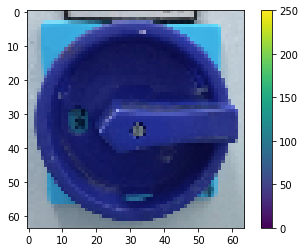

In [12]:
visualize_example(X[4])

In [13]:
X = X / 255.0
X_t = X_t / 255.0

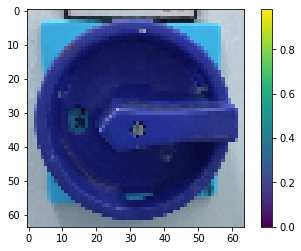

In [14]:
visualize_example(X[4])

In [15]:
# Variables con los datos necesarios
batch_size = 64
num_classes = 2

In [16]:
# Convertimos los valores de y con codificación one hot
y = tf.keras.utils.to_categorical(y, num_classes)
y_t = tf.keras.utils.to_categorical(y_t, num_classes)

X = X.astype('float32')
X_t = X_t.astype('float32')

In [146]:
X_t.shape

(500, 64, 64, 3)

In [147]:
y_t.shape

(500, 2)

## Modelo 1

In [160]:
#lr = 0.001
#epochs = 40

#model = Sequential()

#model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(64,64,3), name='input')) #, input_shape=(64,64,3)
#model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))

#model.add(MaxPooling2D(pool_size=(2,2))) 
#model.add(BatchNormalization())
#model.add(Dropout(0.4))

#model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))

#model.add(MaxPooling2D(pool_size=(2,2))) 
#model.add(BatchNormalization())
#model.add(Dropout(0.6))

#model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))

#model.add(MaxPooling2D(pool_size=(2,2))) 
#model.add(BatchNormalization())
#model.add(Dropout(0.6))

#model.add(Flatten())
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.7))
#model.add(Dense(128, activation='relu'))

# model.add(Dense(2, activation='softmax', name="output"))  # 2 categorías  

#
# RESULTADO sexto intento - sobre 92% en validation, sobre 97% en test
#



# Take a look at the model summary
#model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Conv2D)               (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_15 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 64)       

In [ ]:
#adam = Adam(lr=lr)

#es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
#mc = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True)

#model.compile(loss='binary_crossentropy',
#             optimizer=adam,
#             metrics=['accuracy'])

# Entrenamos el modelo con 20% de validación del training
#history = model.fit(X, y,
#                   batch_size = batch_size,
#                   epochs=epochs,
#                   verbose=1,
#                   validation_split = 0.2,
#                   callbacks=[es, mc])  #Vamos a gastar el 20% del training como validación

## Modelo 2 [Machine Learning Mastery](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)

In [17]:
lr = 0.001
epochs = 40

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

# compile model
# opt = SGD(lr=lr, momentum=0.9)
opt = Nadam(lr=lr)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [19]:
mc = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True)

# Entrenamos el modelo con 20% de validación del training
history = model.fit(X, y,
                   batch_size = batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_split = 0.2,
                   callbacks=[mc])  #Vamos a gastar el 20% del training como validación

Epoch 1/40
19/19 [==============================] - ETA: 0s - loss: 1.8511 - accuracy: 0.6825
Epoch 00001: val_loss improved from inf to 0.11020, saving model to best_model.h5
19/19 [==============================] - 5s 255ms/step - loss: 1.8511 - accuracy: 0.6825 - val_loss: 0.1102 - val_accuracy: 1.0000
Epoch 2/40
19/19 [==============================] - ETA: 0s - loss: 0.0366 - accuracy: 1.0000
Epoch 00002: val_loss improved from 0.11020 to 0.00231, saving model to best_model.h5
19/19 [==============================] - 4s 211ms/step - loss: 0.0366 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 3/40
19/19 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000
Epoch 00003: val_loss improved from 0.00231 to 0.00052, saving model to best_model.h5
19/19 [==============================] - 4s 223ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 5.1877e-04 - val_accuracy: 1.0000
Epoch 4/40
19/19 [==============================] - ETA: 0s - loss:

## Plots and stuff

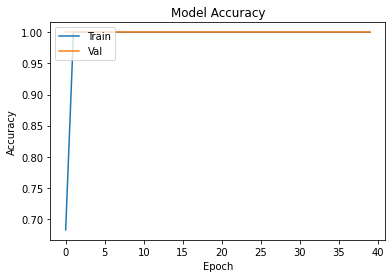

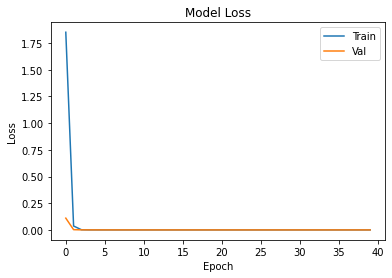

In [20]:
plot_acc(history)
plot_loss(history)

In [21]:
score = model.evaluate(X_t, y_t, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.564361605867816e-08
Test accuracy: 1.0


# Predictions

In [22]:
def visualize_prediction(x, class_index):
    plt.figure()
    plt.imshow(x)
    plt.xlabel(class_index)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [23]:
result = model.predict(X_t[0].reshape(1, 64,64,3))
result

array([[9.003797e-09, 1.000000e+00]], dtype=float32)

In [24]:
predicted_class = MAP_CLASSES[np.argmax(result)]

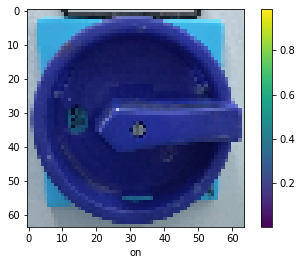

In [25]:
visualize_prediction(X_t[3], predicted_class)

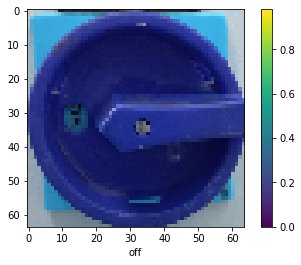

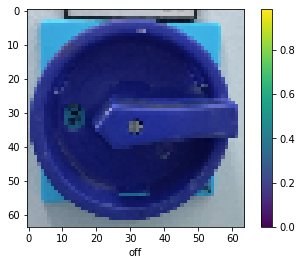

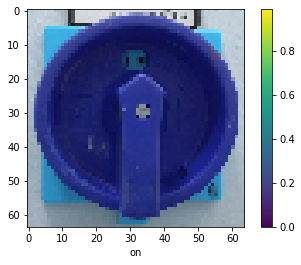

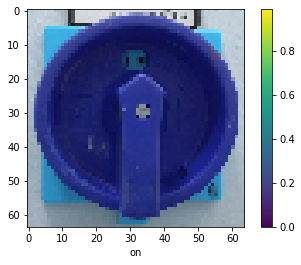

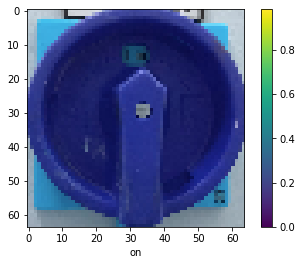

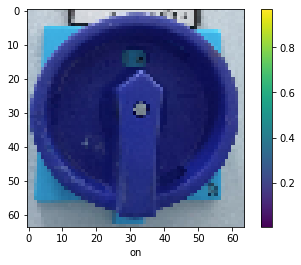

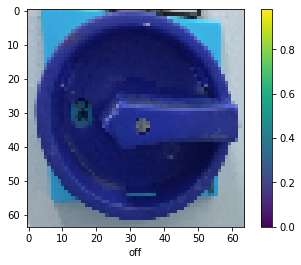

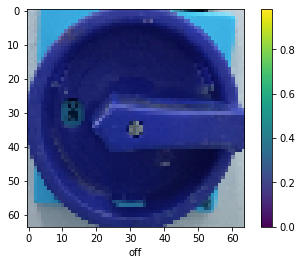

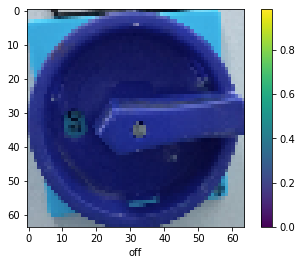

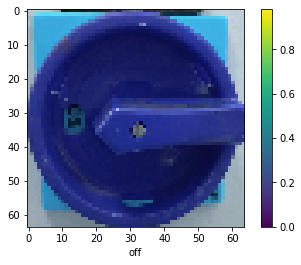

In [26]:
import random

for img in random.sample(list(X_t), 10):
    prediction = MAP_CLASSES[np.argmax(model.predict(img.reshape(1, 64,64,3)))]
    visualize_prediction(img, prediction)